In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os
import math
import datetime
import random
import warnings
warnings.filterwarnings('ignore')

from scipy.stats import skew, norm, boxcox_normmax
from scipy.special import boxcox1p

pd.set_option('display.max_columns', None)

from sklearn.model_selection import *
from sklearn.preprocessing import *
from sklearn.pipeline import *
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier

#train['join_year'] = train['join_year'].astype(int)
#train['join_month'] = train['join_month'].astype(int)
#train['join_day'] = train['join_day'].astype(int)
#train['time_period'] = train['time_period'].astype(str)
#train['time_period'] = train['time_period'].str[:4]

In [2]:
#import datasets
train = pd.read_csv('/home/felix/Downloads/zimnat/Train.csv', parse_dates = ['join_date'])
test = pd.read_csv('/home/felix/Downloads/zimnat/Test.csv', parse_dates = ['join_date'])
submission = pd.read_csv('/home/felix/Downloads/zimnat/SampleSubmission.csv')

In [3]:
#print all dataset shape
print(train.shape, test.shape,submission.shape)

(29132, 29) (10000, 29) (210000, 2)


In [4]:
#Store Products ID in Multidimensional array
products =train[['P5DA', 'RIBP', '8NN1',
       '7POT', '66FJ', 'GYSR', 'SOP4', 'RVSZ', 'PYUQ', 'LJR9', 'N2MW', 'AHXO',
       'BSTQ', 'FM3X', 'K6QO', 'QBOL', 'JWFN', 'JZ9D', 'J9JW', 'GHYX', 'ECY3']]
products_t =test[['P5DA', 'RIBP', '8NN1',
       '7POT', '66FJ', 'GYSR', 'SOP4', 'RVSZ', 'PYUQ', 'LJR9', 'N2MW', 'AHXO',
       'BSTQ', 'FM3X', 'K6QO', 'QBOL', 'JWFN', 'JZ9D', 'J9JW', 'GHYX', 'ECY3']]

In [5]:
#Axis Transformation
train = train.melt(id_vars=train.columns[:8], value_vars=products, var_name = "PCODE", value_name="Label" )
test = test.melt(id_vars=test.columns[:8], value_vars=products_t, var_name = "PCODE", value_name="Label" )

In [6]:
print(train.shape, test.shape, submission.shape)

(611772, 10) (210000, 10) (210000, 2)


In [7]:
#Concatenate new column towards submission requirement
train['ID X PCODE'] = train['ID'] + ' X ' + train['PCODE'];test['ID X PCODE'] = test['ID'] + ' X ' + test['PCODE']

In [8]:
#Re-arrange column (not necessary)
train=train[['ID', 'join_date', 'sex', 'marital_status', 'birth_year', 'branch_code',
       'occupation_code', 'occupation_category_code', 'PCODE','ID X PCODE',  'Label']]
test=test[['ID', 'join_date', 'sex', 'marital_status', 'birth_year', 'branch_code',
       'occupation_code', 'occupation_category_code', 'PCODE','ID X PCODE']]

In [9]:
train.head()

,ID,join_date,sex,marital_status,birth_year,branch_code,occupation_code,occupation_category_code,PCODE,ID X PCODE,Label
0,4WKQSBB,2019-01-02,F,M,1987,1X1H,2A7I,T4MS,P5DA,4WKQSBB X P5DA,0
1,CP5S02H,2019-01-06,F,M,1981,UAOD,2A7I,T4MS,P5DA,CP5S02H X P5DA,0
2,2YKDILJ,2013-01-06,M,U,1991,748L,QZYX,90QI,P5DA,2YKDILJ X P5DA,0
3,2S9E81J,2019-01-08,M,M,1990,1X1H,BP09,56SI,P5DA,2S9E81J X P5DA,0
4,BHDYVFT,2019-01-08,M,M,1990,748L,NO3L,T4MS,P5DA,BHDYVFT X P5DA,0


In [10]:
test.head()

,ID,join_date,sex,marital_status,birth_year,branch_code,occupation_code,occupation_category_code,PCODE,ID X PCODE
0,F86J5PC,2018-01-12,M,M,1984,94KC,DZRV,90QI,P5DA,F86J5PC X P5DA
1,H6141K3,2019-01-10,M,M,1996,1X1H,J9SY,90QI,P5DA,H6141K3 X P5DA
2,RBAYUXZ,2020-01-01,F,W,1968,UAOD,2A7I,T4MS,P5DA,RBAYUXZ X P5DA
3,KCBILBQ,2019-01-02,M,M,1989,94KC,2A7I,T4MS,P5DA,KCBILBQ X P5DA
4,LSEC1ZJ,2020-01-02,F,M,1982,UAOD,0KID,T4MS,P5DA,LSEC1ZJ X P5DA


In [13]:
train.columns

Index(['ID', 'join_date', 'sex', 'marital_status', 'birth_year', 'branch_code',
       'occupation_code', 'occupation_category_code', 'PCODE', 'ID X PCODE',
       'Label', 'age', 'join_year', 'join_month', 'join_day', 'time_period'],
      dtype='object')

In [12]:
train['age'] = 2020 - train['birth_year']
train['join_year'] = train['join_date'].dt.year
train['join_month'] = train['join_date'].dt.month
train['join_day'] = train['join_date'].dt.day
dt = pd.datetime.now().replace(hour=0, minute=0, second=0, microsecond=0)
train['time_period'] = dt - train['join_date']

test['age'] = 2020 - test['birth_year']
test['join_year'] = test['join_date'].dt.year
test['join_month'] = test['join_date'].dt.month
test['join_day'] = test['join_date'].dt.day
dt = pd.datetime.now().replace(hour=0, minute=0, second=0, microsecond=0)
test['time_period'] = dt - test['join_date']

In [14]:
re_col = ['ID', 'join_date', 'sex', 'marital_status', 'birth_year', 'age', 'join_year', 'join_month', 'join_day', 'time_period', 'branch_code', 'occupation_code', 'occupation_category_code', 'PCODE', 'ID X PCODE', 'Label']
train = train.reindex(columns=re_col)
test = test.reindex(columns=re_col)

In [15]:
train.head()

,ID,join_date,sex,marital_status,birth_year,age,join_year,join_month,join_day,time_period,branch_code,occupation_code,occupation_category_code,PCODE,ID X PCODE,Label
0,4WKQSBB,2019-01-02,F,M,1987,33,2019.0,1.0,2.0,586 days,1X1H,2A7I,T4MS,P5DA,4WKQSBB X P5DA,0
1,CP5S02H,2019-01-06,F,M,1981,39,2019.0,1.0,6.0,582 days,UAOD,2A7I,T4MS,P5DA,CP5S02H X P5DA,0
2,2YKDILJ,2013-01-06,M,U,1991,29,2013.0,1.0,6.0,2773 days,748L,QZYX,90QI,P5DA,2YKDILJ X P5DA,0
3,2S9E81J,2019-01-08,M,M,1990,30,2019.0,1.0,8.0,580 days,1X1H,BP09,56SI,P5DA,2S9E81J X P5DA,0
4,BHDYVFT,2019-01-08,M,M,1990,30,2019.0,1.0,8.0,580 days,748L,NO3L,T4MS,P5DA,BHDYVFT X P5DA,0


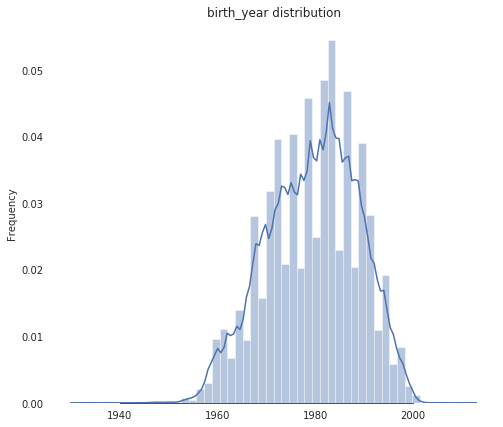

In [28]:
sns.set_style("white")
sns.set_color_codes(palette='deep')
f, ax = plt.subplots(figsize=(8, 7))
#Check the new distribution 
sns.distplot(train['birth_year'], color="b");
ax.xaxis.grid(False)
ax.set(ylabel="Frequency")
ax.set(xlabel="")
ax.set(title="birth_year distribution")
sns.despine(trim=True, left=True)
plt.show()

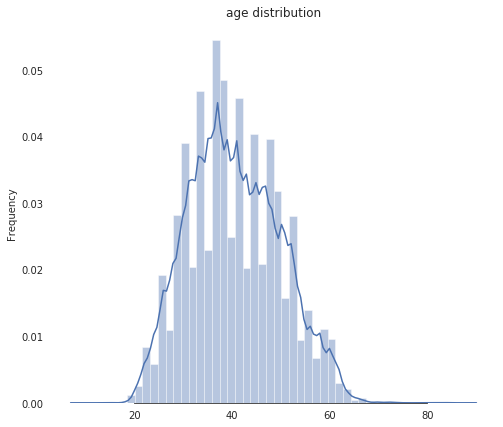

In [29]:
sns.set_style("white")
sns.set_color_codes(palette='deep')
f, ax = plt.subplots(figsize=(8, 7))
#Check the new distribution 
sns.distplot(train['age'], color="b");
ax.xaxis.grid(False)
ax.set(ylabel="Frequency")
ax.set(xlabel="")
ax.set(title="age distribution")
sns.despine(trim=True, left=True)
plt.show()